In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 500) (8569, 1)


,10,133,156,178,204,205,241,273,274,276,...,18662,18670,18684,18922,18923,19018,19048,19051,19158,20109
0,1.302199,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,2.381123,0.0,0.000000,0.0,0.36896,0.0,0.0,0.0
1,1.351171,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.305824,2.919360,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
2,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,1.214231,0.0,...,0.0,0.000000,2.796676,0.0,0.464945,0.0,0.00000,0.0,0.0,0.0
3,0.000000,0.0,0.4175,0.4175,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,1.531937,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
4,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.509045,0.0,...,0.0,0.000000,2.264689,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

500
1024
1024
500
1024
1024


In [5]:
num_elements=len(scDataset)
dim=high_var_gene
print(num_elements,dim)
p=hnswlib.Index(space='cosine',dim=dim)
p.init_index(max_elements=num_elements, ef_construction=100, M=16)
p.set_ef(100)
p.set_num_threads(4)
p.add_items(x_ndarray)

8569 500


In [6]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [7]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [8]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [9]:
class MemoryBank():

    # 初始化，传入参数
    def __init__(self,batch_size,full_data,topK=10):
        self.topK=topK
        self.batch_size=batch_size
        self.bank=None
        self.full_data=full_data

    # 根据在updateBank中更新的hnsw对象以及输入的数据data（这里可以是embedding）提取TopK个近邻的数据
    # 返回的结果是一个形状为[TopK,batch_size,num_genes]的数组，从第一个维度来看，
    # 每个[batch_size,num_genes]的子数组都是根据输入的数据data寻找的一个近邻，一共TopK个
    def generateContrast(self,data):
        if self.bank is not None:
            contrasts=np.empty((self.topK,args.batch_size,args.num_genes))
            labels,distances=self.bank.knn_query(data,k=self.topK)
            
            # print(labels)

            for step,label in enumerate(labels):
                contrasts[:,step]=self.full_data[label.tolist()]
            return contrasts
        else:
            print('Memory Bank has not been initialized......')
            raise NotImplementedError()

    # 根据输入的embedding更新hnsw对象
    def updateBank(self,embedding):
        num_elements=len(embedding)
        dim=embedding.shape[1]
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=num_elements, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(embedding)

In [10]:

# def train(instance_loss,cluster_loss):
#     loss_epoch = 0
#     for step, (data,label) in enumerate(scDataset):
#         optimizer.zero_grad()
        
#         x_i=data.clone().numpy()
        
#         labels, distances = p.knn_query(x_i, k=31)
#         labels=labels.squeeze()
#         contrastive=x_ndarray[labels.tolist()]
#         input=np.row_stack((contrastive,x_i))
#         input_1=input.copy()
#         np.random.shuffle(input_1)
#         x_a=torch.from_numpy(input).to('cuda')
#         x_b=torch.from_numpy(input_1).to('cuda')
        
#         z_i,z_j,c_i,c_j=model(x_a,x_b)
#         loss_instance=instance_loss(z_i,z_j)
#         loss_cluster=cluster_loss(c_i,c_j)
#         loss = loss_instance + loss_cluster
#         loss.backward()
#         optimizer.step()
#         if step % 1000 == 0:
#             print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
#         loss_epoch += loss.item()
#     return loss_epoch


In [11]:
def train(instance_loss,cluster_loss,memory_bank,model,epoch):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        # if epoch<20:
        embedding_data=data.numpy().copy()
        data=data.to('cuda')
        # else:
        #     data=data.to('cuda')
        #     embedding_data=model.forward_embedding(data).cpu().detach().numpy()    
        contrast_samples=memory_bank.generateContrast(embedding_data)
        iter_times=contrast_samples.shape[0]
        for sample in contrast_samples:
            # print(f'sample shape:\n{sample.shape}')
            # print(f'data shape:\n{data.shape}')
            x_i=data.clone()
            x_j=torch.tensor(sample,dtype=torch.float32).to('cuda')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [12]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [13]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [14]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=MemoryBank(batch_size=args.batch_size,full_data=x_ndarray,topK=10)
memory_bank.updateBank(x_ndarray)

for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    # if epoch %20 ==0:
    #     embeddings=np.empty((0,mlp.rep_dim))
    #     model.eval()
    #     with torch.no_grad():
    #         for step, (x, y) in enumerate(scGenDataLoader):
    #             x=x.to('cuda')
    #             embedding=model.forward_embedding(x).cpu().detach().numpy()                 
    #             embeddings=np.row_stack((embeddings,embedding))
    #             memory_bank.updateBank(embeddings)
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,epoch=epoch,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.605802536010742	 loss_cluster: 3.298494815826416
Step [2/8]	 loss_instance: 7.500216960906982	 loss_cluster: 3.298152208328247
Step [4/8]	 loss_instance: 7.228879928588867	 loss_cluster: 3.2971980571746826
Step [6/8]	 loss_instance: 7.05911111831665	 loss_cluster: 3.2937700748443604

Epoch [1/500]	 Loss: 10.64238406419754 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4420 ARI = 0.2749 F = 0.5169 ACC = 0.0106



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.002948760986328	 loss_cluster: 3.28469181060791
Step [2/8]	 loss_instance: 6.891845226287842	 loss_cluster: 3.2636420726776123
Step [4/8]	 loss_instance: 6.778619766235352	 loss_cluster: 3.228989362716675
Step [6/8]	 loss_instance: 6.562294006347656	 loss_cluster: 3.1744723320007324

Epoch [2/500]	 Loss: 10.031001448631287 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4849 ARI = 0.3466 F = 0.4795 ACC = 0.0636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.499810695648193	 loss_cluster: 3.107792854309082
Step [2/8]	 loss_instance: 6.4570488929748535	 loss_cluster: 3.016317129135132
Step [4/8]	 loss_instance: 6.385608196258545	 loss_cluster: 2.918006181716919
Step [6/8]	 loss_instance: 6.354487419128418	 loss_cluster: 2.8145830631256104

Epoch [3/500]	 Loss: 9.36051709651947 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5478 ARI = 0.4826 F = 0.5761 ACC = 0.5818



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.316483497619629	 loss_cluster: 2.755361557006836
Step [2/8]	 loss_instance: 6.33265495300293	 loss_cluster: 2.675257921218872
Step [4/8]	 loss_instance: 6.317012310028076	 loss_cluster: 2.6322505474090576
Step [6/8]	 loss_instance: 6.296203136444092	 loss_cluster: 2.5902867317199707

Epoch [4/500]	 Loss: 8.95573902130127 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6066 ARI = 0.4709 F = 0.5673 ACC = 0.5557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.3195414543151855	 loss_cluster: 2.544644355773926
Step [2/8]	 loss_instance: 6.288091659545898	 loss_cluster: 2.5134196281433105
Step [4/8]	 loss_instance: 6.293845176696777	 loss_cluster: 2.465498924255371
Step [6/8]	 loss_instance: 6.291091442108154	 loss_cluster: 2.436342239379883

Epoch [5/500]	 Loss: 8.742598366737365 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6670 ARI = 0.5373 F = 0.6224 ACC = 0.6116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.301726341247559	 loss_cluster: 2.420271873474121
Step [2/8]	 loss_instance: 6.255966663360596	 loss_cluster: 2.3671560287475586
Step [4/8]	 loss_instance: 6.268630504608154	 loss_cluster: 2.3518543243408203
Step [6/8]	 loss_instance: 6.2511420249938965	 loss_cluster: 2.2962141036987305

Epoch [6/500]	 Loss: 8.588076090812683 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6991 ARI = 0.5605 F = 0.6424 ACC = 0.6177



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.2723493576049805	 loss_cluster: 2.293785810470581
Step [2/8]	 loss_instance: 6.247296333312988	 loss_cluster: 2.2528011798858643
Step [4/8]	 loss_instance: 6.259013652801514	 loss_cluster: 2.2378153800964355
Step [6/8]	 loss_instance: 6.236958026885986	 loss_cluster: 2.195171356201172

Epoch [7/500]	 Loss: 8.449056541919708 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6921 ARI = 0.5187 F = 0.6081 ACC = 0.6157



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.233893871307373	 loss_cluster: 2.16152024269104
Step [2/8]	 loss_instance: 6.247090816497803	 loss_cluster: 2.1230785846710205
Step [4/8]	 loss_instance: 6.228017330169678	 loss_cluster: 2.0989630222320557
Step [6/8]	 loss_instance: 6.2354254722595215	 loss_cluster: 2.0641047954559326

Epoch [8/500]	 Loss: 8.312680208683014 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6841 ARI = 0.4853 F = 0.5820 ACC = 0.5518



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.239055156707764	 loss_cluster: 2.031430244445801
Step [2/8]	 loss_instance: 6.250960350036621	 loss_cluster: 2.035123825073242
Step [4/8]	 loss_instance: 6.247097015380859	 loss_cluster: 2.036191940307617
Step [6/8]	 loss_instance: 6.230324745178223	 loss_cluster: 2.0185024738311768

Epoch [9/500]	 Loss: 8.202425122261047 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6835 ARI = 0.4903 F = 0.5881 ACC = 0.5481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.219405174255371	 loss_cluster: 1.970725655555725
Step [2/8]	 loss_instance: 6.206035137176514	 loss_cluster: 1.9227458238601685
Step [4/8]	 loss_instance: 6.221778392791748	 loss_cluster: 1.9529346227645874
Step [6/8]	 loss_instance: 6.207217216491699	 loss_cluster: 1.9653644561767578

Epoch [10/500]	 Loss: 8.142011654376983 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6880 ARI = 0.5066 F = 0.6032 ACC = 0.5739



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.213449954986572	 loss_cluster: 1.9656513929367065
Step [2/8]	 loss_instance: 6.194418907165527	 loss_cluster: 1.9411550760269165
Step [4/8]	 loss_instance: 6.198859691619873	 loss_cluster: 1.9234203100204468
Step [6/8]	 loss_instance: 6.181586265563965	 loss_cluster: 1.8856600522994995

Epoch [11/500]	 Loss: 8.081388747692108 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6827 ARI = 0.4763 F = 0.5804 ACC = 0.5381



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.2043137550354	 loss_cluster: 1.9223978519439697
Step [2/8]	 loss_instance: 6.201807022094727	 loss_cluster: 1.9093172550201416
Step [4/8]	 loss_instance: 6.202168941497803	 loss_cluster: 1.8998303413391113
Step [6/8]	 loss_instance: 6.191002368927002	 loss_cluster: 1.9320743083953857

Epoch [12/500]	 Loss: 8.045586776733398 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6586 ARI = 0.4339 F = 0.5435 ACC = 0.5209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.192643642425537	 loss_cluster: 1.8882997035980225
Step [2/8]	 loss_instance: 6.204882621765137	 loss_cluster: 1.868762493133545
Step [4/8]	 loss_instance: 6.202204704284668	 loss_cluster: 1.8836714029312134
Step [6/8]	 loss_instance: 6.184475898742676	 loss_cluster: 1.8623270988464355

Epoch [13/500]	 Loss: 8.003964734077453 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6672 ARI = 0.4175 F = 0.5299 ACC = 0.4889



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.179062843322754	 loss_cluster: 1.8709397315979004
Step [2/8]	 loss_instance: 6.189032077789307	 loss_cluster: 1.8579070568084717
Step [4/8]	 loss_instance: 6.1699442863464355	 loss_cluster: 1.839377999305725
Step [6/8]	 loss_instance: 6.174042701721191	 loss_cluster: 1.847447156906128

Epoch [14/500]	 Loss: 7.972099727392196 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6698 ARI = 0.4187 F = 0.5321 ACC = 0.4869



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1628265380859375	 loss_cluster: 1.8337055444717407
Step [2/8]	 loss_instance: 6.161324977874756	 loss_cluster: 1.8458514213562012
Step [4/8]	 loss_instance: 6.175750255584717	 loss_cluster: 1.826237678527832
Step [6/8]	 loss_instance: 6.1824049949646	 loss_cluster: 1.867727518081665

Epoch [15/500]	 Loss: 7.945363408327102 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6578 ARI = 0.3939 F = 0.5110 ACC = 0.4381



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.169241905212402	 loss_cluster: 1.8589268922805786
Step [2/8]	 loss_instance: 6.164672374725342	 loss_cluster: 1.8295924663543701
Step [4/8]	 loss_instance: 6.164198875427246	 loss_cluster: 1.808733344078064
Step [6/8]	 loss_instance: 6.16874361038208	 loss_cluster: 1.8306431770324707

Epoch [16/500]	 Loss: 7.933778989315033 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6629 ARI = 0.4054 F = 0.5224 ACC = 0.4651



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.16708517074585	 loss_cluster: 1.8041352033615112
Step [2/8]	 loss_instance: 6.168508052825928	 loss_cluster: 1.8247803449630737
Step [4/8]	 loss_instance: 6.166535377502441	 loss_cluster: 1.844813585281372
Step [6/8]	 loss_instance: 6.167393207550049	 loss_cluster: 1.8276793956756592

Epoch [17/500]	 Loss: 7.915990072488785 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6699 ARI = 0.4048 F = 0.5221 ACC = 0.4631



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.181199550628662	 loss_cluster: 1.8411145210266113
Step [2/8]	 loss_instance: 6.179075717926025	 loss_cluster: 1.8306950330734253
Step [4/8]	 loss_instance: 6.179609298706055	 loss_cluster: 1.8288929462432861
Step [6/8]	 loss_instance: 6.1687211990356445	 loss_cluster: 1.8162174224853516

Epoch [18/500]	 Loss: 7.90796177983284 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6781 ARI = 0.4084 F = 0.5258 ACC = 0.4540



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.159618854522705	 loss_cluster: 1.8151140213012695
Step [2/8]	 loss_instance: 6.145699977874756	 loss_cluster: 1.8076369762420654
Step [4/8]	 loss_instance: 6.138365268707275	 loss_cluster: 1.7851632833480835
Step [6/8]	 loss_instance: 6.176680088043213	 loss_cluster: 1.806716799736023

Epoch [19/500]	 Loss: 7.887245786190033 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6876 ARI = 0.4174 F = 0.5342 ACC = 0.4796



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.155475616455078	 loss_cluster: 1.8026297092437744
Step [2/8]	 loss_instance: 6.1624908447265625	 loss_cluster: 1.8125909566879272
Step [4/8]	 loss_instance: 6.1522722244262695	 loss_cluster: 1.7893182039260864
Step [6/8]	 loss_instance: 6.165623188018799	 loss_cluster: 1.803975224494934

Epoch [20/500]	 Loss: 7.870034086704254 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6883 ARI = 0.4191 F = 0.5352 ACC = 0.4873



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.172865867614746	 loss_cluster: 1.8135920763015747
Step [2/8]	 loss_instance: 6.161651134490967	 loss_cluster: 1.7878448963165283
Step [4/8]	 loss_instance: 6.1517815589904785	 loss_cluster: 1.7818608283996582
Step [6/8]	 loss_instance: 6.133202075958252	 loss_cluster: 1.7691960334777832

Epoch [21/500]	 Loss: 7.8582071185112 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6850 ARI = 0.4128 F = 0.5311 ACC = 0.4556



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.150786399841309	 loss_cluster: 1.7951045036315918
Step [2/8]	 loss_instance: 6.156321048736572	 loss_cluster: 1.8073301315307617
Step [4/8]	 loss_instance: 6.1557793617248535	 loss_cluster: 1.7912421226501465
Step [6/8]	 loss_instance: 6.131516933441162	 loss_cluster: 1.767217993736267

Epoch [22/500]	 Loss: 7.849567312002182 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6934 ARI = 0.4191 F = 0.5367 ACC = 0.4734



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.146810054779053	 loss_cluster: 1.7900967597961426
Step [2/8]	 loss_instance: 6.131096839904785	 loss_cluster: 1.7525968551635742
Step [4/8]	 loss_instance: 6.130454063415527	 loss_cluster: 1.7640479803085327
Step [6/8]	 loss_instance: 6.157134056091309	 loss_cluster: 1.7993518114089966

Epoch [23/500]	 Loss: 7.836798685789108 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6904 ARI = 0.4147 F = 0.5330 ACC = 0.4637



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.149798393249512	 loss_cluster: 1.7812880277633667
Step [2/8]	 loss_instance: 6.125747203826904	 loss_cluster: 1.7672357559204102
Step [4/8]	 loss_instance: 6.1364850997924805	 loss_cluster: 1.7754228115081787
Step [6/8]	 loss_instance: 6.125479221343994	 loss_cluster: 1.7604840993881226

Epoch [24/500]	 Loss: 7.835662090778351 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6920 ARI = 0.4193 F = 0.5365 ACC = 0.4917



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.153750896453857	 loss_cluster: 1.7859747409820557
Step [2/8]	 loss_instance: 6.134681701660156	 loss_cluster: 1.767674446105957
Step [4/8]	 loss_instance: 6.14284610748291	 loss_cluster: 1.7990882396697998
Step [6/8]	 loss_instance: 6.130917549133301	 loss_cluster: 1.773034691810608

Epoch [25/500]	 Loss: 7.840178847312927 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6940 ARI = 0.4202 F = 0.5383 ACC = 0.4602



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.136905670166016	 loss_cluster: 1.7727813720703125
Step [2/8]	 loss_instance: 6.134117603302002	 loss_cluster: 1.760221242904663
Step [4/8]	 loss_instance: 6.1508355140686035	 loss_cluster: 1.7828823328018188
Step [6/8]	 loss_instance: 6.150566101074219	 loss_cluster: 1.7586829662322998

Epoch [26/500]	 Loss: 7.823596668243408 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7008 ARI = 0.4249 F = 0.5420 ACC = 0.4788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.125777721405029	 loss_cluster: 1.758803129196167
Step [2/8]	 loss_instance: 6.143424034118652	 loss_cluster: 1.77590811252594
Step [4/8]	 loss_instance: 6.145220756530762	 loss_cluster: 1.7703100442886353
Step [6/8]	 loss_instance: 6.117657661437988	 loss_cluster: 1.7467979192733765

Epoch [27/500]	 Loss: 7.817172569036484 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6958 ARI = 0.4231 F = 0.5410 ACC = 0.4882



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.14788818359375	 loss_cluster: 1.7846696376800537
Step [2/8]	 loss_instance: 6.135451316833496	 loss_cluster: 1.7796632051467896
Step [4/8]	 loss_instance: 6.125319957733154	 loss_cluster: 1.7441794872283936
Step [6/8]	 loss_instance: 6.109144687652588	 loss_cluster: 1.7482640743255615

Epoch [28/500]	 Loss: 7.812838906049729 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6975 ARI = 0.4236 F = 0.5415 ACC = 0.4703



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.131037712097168	 loss_cluster: 1.7680470943450928
Step [2/8]	 loss_instance: 6.138340950012207	 loss_cluster: 1.7733863592147827
Step [4/8]	 loss_instance: 6.135255813598633	 loss_cluster: 1.7602832317352295
Step [6/8]	 loss_instance: 6.131265163421631	 loss_cluster: 1.761677861213684

Epoch [29/500]	 Loss: 7.813803261518478 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.4205 F = 0.5386 ACC = 0.4624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.126064300537109	 loss_cluster: 1.7609587907791138
Step [2/8]	 loss_instance: 6.121450424194336	 loss_cluster: 1.754947543144226
Step [4/8]	 loss_instance: 6.118929862976074	 loss_cluster: 1.756988525390625
Step [6/8]	 loss_instance: 6.11179256439209	 loss_cluster: 1.7504690885543823

Epoch [30/500]	 Loss: 7.807511150836945 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6973 ARI = 0.4233 F = 0.5420 ACC = 0.4647



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.133891582489014	 loss_cluster: 1.7709572315216064
Step [2/8]	 loss_instance: 6.13728141784668	 loss_cluster: 1.7679545879364014
Step [4/8]	 loss_instance: 6.112237453460693	 loss_cluster: 1.7279280424118042
Step [6/8]	 loss_instance: 6.1189961433410645	 loss_cluster: 1.7434955835342407

Epoch [31/500]	 Loss: 7.7972193419933316 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6993 ARI = 0.4227 F = 0.5414 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.123493671417236	 loss_cluster: 1.7495355606079102
Step [2/8]	 loss_instance: 6.129993915557861	 loss_cluster: 1.7717769145965576
Step [4/8]	 loss_instance: 6.125223159790039	 loss_cluster: 1.7503780126571655
Step [6/8]	 loss_instance: 6.128719329833984	 loss_cluster: 1.7476788759231567

Epoch [32/500]	 Loss: 7.796216481924057 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.4205 F = 0.5385 ACC = 0.4701



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.120968341827393	 loss_cluster: 1.759186863899231
Step [2/8]	 loss_instance: 6.112245082855225	 loss_cluster: 1.7398886680603027
Step [4/8]	 loss_instance: 6.119399070739746	 loss_cluster: 1.7394180297851562
Step [6/8]	 loss_instance: 6.134914875030518	 loss_cluster: 1.761181116104126

Epoch [33/500]	 Loss: 7.784367334842682 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6943 ARI = 0.4184 F = 0.5367 ACC = 0.4550



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.123078346252441	 loss_cluster: 1.7639069557189941
Step [2/8]	 loss_instance: 6.105863571166992	 loss_cluster: 1.7297332286834717
Step [4/8]	 loss_instance: 6.091200351715088	 loss_cluster: 1.7264933586120605
Step [6/8]	 loss_instance: 6.133548259735107	 loss_cluster: 1.7599021196365356

Epoch [34/500]	 Loss: 7.783705848455429 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6972 ARI = 0.4210 F = 0.5393 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.104728698730469	 loss_cluster: 1.7264232635498047
Step [2/8]	 loss_instance: 6.112427234649658	 loss_cluster: 1.7674740552902222
Step [4/8]	 loss_instance: 6.104313850402832	 loss_cluster: 1.7305803298950195
Step [6/8]	 loss_instance: 6.125931262969971	 loss_cluster: 1.786038875579834

Epoch [35/500]	 Loss: 7.788032788038254 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6894 ARI = 0.4202 F = 0.5381 ACC = 0.4984



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.125824928283691	 loss_cluster: 1.7466374635696411
Step [2/8]	 loss_instance: 6.104837894439697	 loss_cluster: 1.7356667518615723
Step [4/8]	 loss_instance: 6.112560272216797	 loss_cluster: 1.7526590824127197
Step [6/8]	 loss_instance: 6.1205244064331055	 loss_cluster: 1.7432339191436768

Epoch [36/500]	 Loss: 7.782621741294861 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6931 ARI = 0.4184 F = 0.5367 ACC = 0.4669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.126101493835449	 loss_cluster: 1.7579940557479858
Step [2/8]	 loss_instance: 6.1135101318359375	 loss_cluster: 1.7437399625778198
Step [4/8]	 loss_instance: 6.100010395050049	 loss_cluster: 1.7261919975280762
Step [6/8]	 loss_instance: 6.115567684173584	 loss_cluster: 1.7325125932693481

Epoch [37/500]	 Loss: 7.77318223118782 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6956 ARI = 0.4213 F = 0.5398 ACC = 0.4731



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.114914894104004	 loss_cluster: 1.7485160827636719
Step [2/8]	 loss_instance: 6.109345436096191	 loss_cluster: 1.7463351488113403
Step [4/8]	 loss_instance: 6.111435890197754	 loss_cluster: 1.7422189712524414
Step [6/8]	 loss_instance: 6.108887672424316	 loss_cluster: 1.7469701766967773

Epoch [38/500]	 Loss: 7.776067698001862 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6944 ARI = 0.4166 F = 0.5359 ACC = 0.4722



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.121730804443359	 loss_cluster: 1.7630490064620972
Step [2/8]	 loss_instance: 6.10279655456543	 loss_cluster: 1.7265517711639404
Step [4/8]	 loss_instance: 6.101364612579346	 loss_cluster: 1.7446391582489014
Step [6/8]	 loss_instance: 6.119449615478516	 loss_cluster: 1.7368309497833252

Epoch [39/500]	 Loss: 7.772554051876068 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4243 F = 0.5427 ACC = 0.4727



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.128156661987305	 loss_cluster: 1.753042459487915
Step [2/8]	 loss_instance: 6.104222774505615	 loss_cluster: 1.724199891090393
Step [4/8]	 loss_instance: 6.1336750984191895	 loss_cluster: 1.7801525592803955
Step [6/8]	 loss_instance: 6.102318286895752	 loss_cluster: 1.727840542793274

Epoch [40/500]	 Loss: 7.766756975650788 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6990 ARI = 0.4242 F = 0.5423 ACC = 0.4683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.117710590362549	 loss_cluster: 1.7624534368515015
Step [2/8]	 loss_instance: 6.096018314361572	 loss_cluster: 1.7292594909667969
Step [4/8]	 loss_instance: 6.114806652069092	 loss_cluster: 1.7388097047805786
Step [6/8]	 loss_instance: 6.122564315795898	 loss_cluster: 1.7574305534362793

Epoch [41/500]	 Loss: 7.770528692007065 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6926 ARI = 0.4220 F = 0.5396 ACC = 0.4810



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.114209175109863	 loss_cluster: 1.7293109893798828
Step [2/8]	 loss_instance: 6.097865104675293	 loss_cluster: 1.735992431640625
Step [4/8]	 loss_instance: 6.124251365661621	 loss_cluster: 1.7641233205795288
Step [6/8]	 loss_instance: 6.107422828674316	 loss_cluster: 1.75149405002594

Epoch [42/500]	 Loss: 7.778827118873596 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6946 ARI = 0.4219 F = 0.5400 ACC = 0.4817



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.103654861450195	 loss_cluster: 1.7650742530822754
Step [2/8]	 loss_instance: 6.089182376861572	 loss_cluster: 1.7324283123016357
Step [4/8]	 loss_instance: 6.092373371124268	 loss_cluster: 1.7293310165405273
Step [6/8]	 loss_instance: 6.101668834686279	 loss_cluster: 1.7155804634094238

Epoch [43/500]	 Loss: 7.763056242465973 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6986 ARI = 0.4207 F = 0.5388 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.088377952575684	 loss_cluster: 1.7174830436706543
Step [2/8]	 loss_instance: 6.103189945220947	 loss_cluster: 1.743072509765625
Step [4/8]	 loss_instance: 6.106197357177734	 loss_cluster: 1.7453815937042236
Step [6/8]	 loss_instance: 6.100414276123047	 loss_cluster: 1.7349194288253784

Epoch [44/500]	 Loss: 7.755812698602677 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.4253 F = 0.5427 ACC = 0.4822



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.08744478225708	 loss_cluster: 1.7115639448165894
Step [2/8]	 loss_instance: 6.095665454864502	 loss_cluster: 1.7198718786239624
Step [4/8]	 loss_instance: 6.11144495010376	 loss_cluster: 1.7379335165023804
Step [6/8]	 loss_instance: 6.115493297576904	 loss_cluster: 1.7371283769607544

Epoch [45/500]	 Loss: 7.751113003492355 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6986 ARI = 0.4212 F = 0.5395 ACC = 0.4558



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.107014179229736	 loss_cluster: 1.7546851634979248
Step [2/8]	 loss_instance: 6.103837490081787	 loss_cluster: 1.750370979309082
Step [4/8]	 loss_instance: 6.127023696899414	 loss_cluster: 1.7599292993545532
Step [6/8]	 loss_instance: 6.0925140380859375	 loss_cluster: 1.7306770086288452

Epoch [46/500]	 Loss: 7.756360465288163 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4262 F = 0.5440 ACC = 0.4851



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1013898849487305	 loss_cluster: 1.7440556287765503
Step [2/8]	 loss_instance: 6.109910011291504	 loss_cluster: 1.7391784191131592
Step [4/8]	 loss_instance: 6.122477054595947	 loss_cluster: 1.7467572689056396


KeyboardInterrupt: 

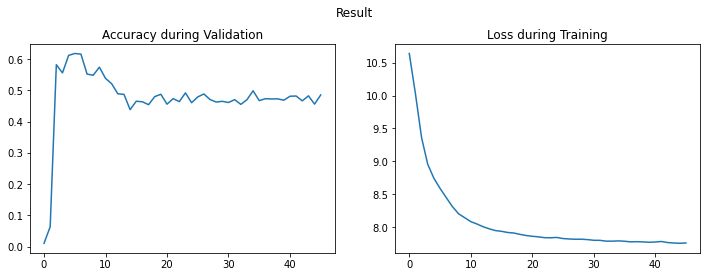

In [15]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

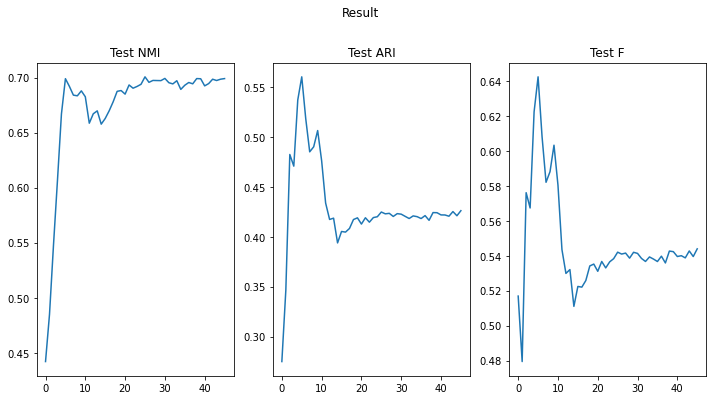

In [16]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()